In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import math
import gurobipy as gb

In [2]:
from customer import Customer
from locker_customer import LockerCustomer
from door_to_door_customer import DoorToDoorCustomer
from location import Location
from store import *
from vehicle import Vehicle
from vehicle_type import VehicleType

In [18]:
# input
custom_setup = False
C = 15
L = 3

map_size = 100
ratio_locker_customers = 0.3

In [19]:
def get_nearest_store(stores, location):
    min_distance = float("inf")
    nearest_store = stores[0]
    for store in stores:
        distance = location.euclidean_distance(store.location)
        if distance < min_distance:
            min_distance = distance
            nearest_store = store
    return nearest_store

In [20]:
# generate data
if custom_setup:
    C = 8
    L = 2
    stores = []
    stores.append(Store(0, Location(60, 50), capacity=float("inf"), is_warehouse=True))
    stores.append(Store(1, Location(30, 50), capacity=math.ceil(0.8 * C / L)))
    stores.append(Store(2, Location(50, 20), capacity=math.ceil(0.8 * C / L)))

    customers = []
    customers.append(LockerCustomer(0, 0, Location(10, 28), stores[1]))
    customers.append(DoorToDoorCustomer(1, 0, Location(20, 40)))
    customers.append(DoorToDoorCustomer(2, 1, Location(15, 70)))
    customers.append(DoorToDoorCustomer(3, 2, Location(30, 70)))
    customers.append(DoorToDoorCustomer(4, 3, Location(80, 60)))
    customers.append(LockerCustomer(5, 1, Location(70, 40), stores[0]))
    customers.append(DoorToDoorCustomer(6, 4, Location(90, 50)))
    customers.append(LockerCustomer(7, 2, Location(40, 15), stores[2]))
else:
    stores = []
    stores.append(Store(0, Location(random.randint(0, map_size), random.randint(0, map_size)), capacity=float("inf"), is_warehouse=True))
    for l in range(L):
        stores.append(Store(l+1, Location(random.randint(0, map_size), random.randint(0, map_size)), capacity=math.ceil(0.8 * C / L)))

    customers = []
    counter_locker_customer = 0
    counter_door_to_door_customer = 0
    for c in range(C):
        location = Location(random.randint(0, map_size), random.randint(0, map_size))
        if random.random() < ratio_locker_customers:
            # customer locker
            customers.append(LockerCustomer(c, counter_locker_customer, location, get_nearest_store(stores, location)))
            counter_locker_customer += 1
        else:
            # door to door customer
            customers.append(DoorToDoorCustomer(c, counter_door_to_door_customer, location))
            counter_door_to_door_customer += 1

In [21]:
# create sets
C_L = list(filter(lambda customer: type(customer) == LockerCustomer, customers))
C_D = list(filter(lambda customer: type(customer) == DoorToDoorCustomer, customers))
lockers = list(filter(lambda store: not store.is_warehouse, stores))

sum_W_l = 0
for store in stores:
    if not store.is_warehouse:
        sum_W_l += store.capacity

# define all the vehicles
if custom_setup:
    vehicles = []
    vehicles.append(Vehicle(0, VehicleType.LOCKER_SUPPLY, stores[0], math.ceil(0.8 * sum_W_l)))
    vehicles.append(Vehicle(1, VehicleType.PF, stores[0], math.ceil(0.5 * len(C_D))))
    vehicles.append(Vehicle(2, VehicleType.LF, stores[1], math.ceil(0.6 * stores[1].capacity)))
    vehicles.append(Vehicle(3, VehicleType.LF, stores[2], math.ceil(0.6 * stores[2].capacity)))
else:
    vehicles = []
    for store in stores:
        if store.is_warehouse:
            vehicles.append(Vehicle(0, VehicleType.LOCKER_SUPPLY, store, math.ceil(0.8 * sum_W_l)))
            vehicles.append(Vehicle(1, VehicleType.PF, store, math.ceil(0.5 * len(C_D))))
        else:
            vehicles.append(Vehicle(store.index+1, VehicleType.LF, store, math.ceil(0.6 * store.capacity)))

In [22]:
# define some np.array to plot the map
CD_location = np.array([[0,0]])
CL_location = np.array([[0,0]])
L_location = np.array([[0,0]])
W_location = np.array([[0,0]])

for store in stores:
    if store.is_warehouse:
        W_location = np.vstack([W_location, [store.location.x, store.location.y]])
    else:
        L_location = np.vstack([L_location, [store.location.x, store.location.y]])
for cd in C_D:
    CD_location = np.vstack([CD_location, [cd.location.x, cd.location.y]])
for cl in C_L:
    CL_location = np.vstack([CL_location, [cl.location.x, cl.location.y]])

CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)
L_location = np.delete(L_location, 0, 0)
W_location = np.delete(W_location, 0, 0)

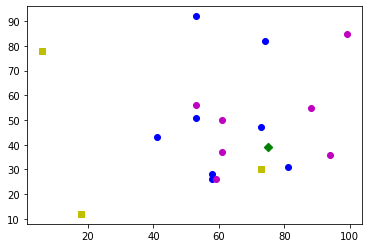

In [23]:
# plot the map
plt.scatter(CD_location[:,0],CD_location[:,1],color='b')
plt.scatter(CL_location[:,0],CL_location[:,1],color='m')
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')

In [24]:
#calcolo la matrice delle distanze:

all_locations = np.array([])
all_locations = np.append(all_locations,W_location)
all_locations = np.vstack([all_locations,L_location])
all_locations = np.vstack([all_locations,CD_location])
all_locations = np.vstack([all_locations,CL_location])

all_buildings = stores + C_D + C_L

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()
print(dist_matrix)


             W          L1         L2         L3        CD0        CD1  \
W     0.000000   63.071388   9.219544  79.259069   8.246211  57.384667   
L1   63.071388    0.000000  57.870545  67.082039  65.192024  87.321246   
L2    9.219544   57.870545   0.000000  82.419658  17.000000  65.145990   
L3   79.259069   67.082039  82.419658   0.000000  73.824115  49.040799   
CD0   8.246211   65.192024  17.000000  73.824115   0.000000  49.244289   
CD1  57.384667   87.321246  65.145990  49.040799  49.244289   0.000000   
CD2  25.059928   52.402290  29.000000  54.203321  20.396078  41.000000   
CD3  20.248457   43.081318  15.132746  72.138755  24.207437  64.195015   
CD4  34.234486   38.600518  34.539832  49.497475  32.249031  50.447993   
CD5  43.011626   89.643739  52.009614  68.117545  35.014283  23.259407   
CD6  10.000000   65.802736   8.062258  88.509886  17.888544  67.119297   
CD7  21.400935   42.379240  15.524175  73.539105  25.806976  66.189123   
CL0  20.615528   43.324358  14.560220 

In [25]:
#filter data

supply_distances_matrix = dist_matrix.filter(items=stores, axis=1)
supply_distances_matrix = supply_distances_matrix.filter(items=stores, axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=[stores[0]] + C_D, axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=[stores[0]] + C_D, axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=lockers+C_D, axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers + C_D, axis=0)
print(LF_distances_matrix)

            W         L1         L2         L3
W    0.000000  63.071388   9.219544  79.259069
L1  63.071388   0.000000  57.870545  67.082039
L2   9.219544  57.870545   0.000000  82.419658
L3  79.259069  67.082039  82.419658   0.000000
             W        CD0        CD1        CD2        CD3        CD4  \
W     0.000000   8.246211  57.384667  25.059928  20.248457  34.234486   
CD0   8.246211   0.000000  49.244289  20.396078  24.207437  32.249031   
CD1  57.384667  49.244289   0.000000  41.000000  64.195015  50.447993   
CD2  25.059928  20.396078  41.000000   0.000000  23.537205  14.422205   
CD3  20.248457  24.207437  64.195015  23.537205   0.000000  22.671568   
CD4  34.234486  32.249031  50.447993  14.422205  22.671568   0.000000   
CD5  43.011626  35.014283  23.259407  37.443290  56.320511  51.088159   
CD6  10.000000  17.888544  67.119297  34.409301  23.194827  41.761226   
CD7  21.400935  25.806976  66.189123  25.495098   2.000000  24.041631   

           CD5        CD6        C

In [26]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75

PF_delivery_cost = pi*PF_distances_matrix
LF_delivery_cost = pi_l*LF_distances_matrix
supply_cost = pi_L*supply_distances_matrix
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)


            W         L1         L2         L3
W    0.000000  47.303541   6.914658  59.444302
L1  47.303541   0.000000  43.402909  50.311529
L2   6.914658  43.402909   0.000000  61.814743
L3  59.444302  50.311529  61.814743   0.000000
             W        CD0        CD1        CD2        CD3        CD4  \
W     0.000000   8.246211  57.384667  25.059928  20.248457  34.234486   
CD0   8.246211   0.000000  49.244289  20.396078  24.207437  32.249031   
CD1  57.384667  49.244289   0.000000  41.000000  64.195015  50.447993   
CD2  25.059928  20.396078  41.000000   0.000000  23.537205  14.422205   
CD3  20.248457  24.207437  64.195015  23.537205   0.000000  22.671568   
CD4  34.234486  32.249031  50.447993  14.422205  22.671568   0.000000   
CD5  43.011626  35.014283  23.259407  37.443290  56.320511  51.088159   
CD6  10.000000  17.888544  67.119297  34.409301  23.194827  41.761226   
CD7  21.400935  25.806976  66.189123  25.495098   2.000000  24.041631   

           CD5        CD6        C

In [27]:

LF_delivery_cost_multidim = np.zeros((L,len(C_D)+1,len(C_D)+1))

for i in range(L):
    l = [0]
    l[0]=lockers[i]
    ls = LF_delivery_cost.filter(items=l+C_D,axis=1)
    ls = ls.filter(items=l+C_D,axis=0)
    print(ls)
    lt = ls.to_numpy()
    for j in range(1+len(C_D)):
        for k in range(1+len(C_D)):
            LF_delivery_cost_multidim[i][j][k]=lt[j][k]


            L1        CD0        CD1        CD2        CD3        CD4  \
L1    0.000000  55.413220  74.223059  44.541947  36.619121  32.810440   
CD0  55.413220   0.000000  41.857646  17.336666  20.576321  27.411676   
CD1  74.223059  41.857646   0.000000  34.850000  54.565763  42.880794   
CD2  44.541947  17.336666  34.850000   0.000000  20.006624  12.258874   
CD3  36.619121  20.576321  54.565763  20.006624   0.000000  19.270833   
CD4  32.810440  27.411676  42.880794  12.258874  19.270833   0.000000   
CD5  76.197178  29.762140  19.770496  31.826797  47.872435  43.424935   
CD6  55.932325  15.205262  57.051402  29.247906  19.715603  35.497042   
CD7  36.022354  21.935929  56.260755  21.670833   1.700000  20.435386   

           CD5        CD6        CD7  
L1   76.197178  55.932325  36.022354  
CD0  29.762140  15.205262  21.935929  
CD1  19.770496  57.051402  56.260755  
CD2  31.826797  29.247906  21.670833  
CD3  47.872435  19.715603   1.700000  
CD4  43.424935  35.497042  20.43538

In [28]:
col_ind = []
d_ak_k=[]
index_close_locker = []
min_value = []
Sk_def=[]
OC = []
position_sk = []
position_cl = []
pck = np.array([])
locker_where_oc_goes=[]
#compensation
compensation_locations = np.array([])
compensation_locations = np.append(compensation_locations,W_location)
compensation_locations = np.vstack([compensation_locations,L_location])
compensation_locations = np.vstack([compensation_locations,CD_location])

df_compensation = pd.DataFrame(compensation_locations, columns=['xcord', 'ycord'], index=stores+C_D)
compensation_matrix= pd.DataFrame(distance_matrix(df_compensation.values, df_compensation.values), index=df_compensation.index, columns=df_compensation.index)


distance_matrix_customer_locker_store = dist_matrix.filter(items=C_L,axis=1)
distance_matrix_customer_locker_store = distance_matrix_customer_locker_store.filter(items=stores,axis=0)



closest_store_to_CL = distance_matrix_customer_locker_store.idxmin()
print("-------distance_matrix_customer_locker_store----------")
print(distance_matrix_customer_locker_store)
print("----------distance_matrix_customer_locker_store.idxmin()-------------------")
print(distance_matrix_customer_locker_store.idxmin())


min_value_col = distance_matrix_customer_locker_store.min()
print("-----------min_value_col------------")
print(min_value_col)

for i in range(len(closest_store_to_CL)):
    index_close_locker.append(str(closest_store_to_CL[i]))
    min_value.append(min_value_col[i])
print("-----------index_close_locker----------")
print(index_close_locker)
print("----------min_value----------------")
print(min_value)


print("index_close_locker-----------------------------")
print(index_close_locker)
print("compensation_matrix-------------------------------")
print(compensation_matrix)
#d_ak_c=d_ak_c.filter(items=C_D,axis=0)
#print("--------------d_ak_c----------------")
#print(d_ak_c)

for i in range(len(C_L)):
    col_ind.append("D_"+str(index_close_locker[i])+"_"+str(C_L[i].index))
print(col_ind)

d_ak_k = pd.DataFrame(min_value, index=col_ind)
print(d_ak_k)

pre_d_c_k = dist_matrix.filter(items=C_D,axis=0)
pre_d_c_k = pre_d_c_k.filter(items=C_L,axis=1)
print("--------pre_d_c_k-----------------------")
print(pre_d_c_k)

d_ak_c = pd.DataFrame()

# insert d_c_k
for cl in C_L:
    # Using DataFrame.insert() to add a column
    store = cl.store
    array = []
    for cd in C_D:
        distance = store.location.euclidean_distance(cd.location)
        array.append(distance)
    d_ak_c.insert(len(d_ak_c.columns), store, array, True)


print("-------------- d_ak_c after insertion -------------------")
print(d_ak_c)


d_c_k = dist_matrix.filter(items=C_D,axis=0)
d_c_k = d_c_k.filter(items=C_L,axis=1)

print("-------------- d_c_k after filter -------------------")
print(d_c_k)

print("===========d_ak_c==============")
print(d_ak_c)
print("=============d_c_k============")
print(d_c_k)
print("=========================")

sum_dck_dakc = d_ak_c.to_numpy()+d_c_k.to_numpy()
print("--------------sum_dck_dakc--------------------")
print(sum_dck_dakc)

def find_Sk(cd,cl):
    S_K_i = []
    if sum_dck_dakc[cl][cd]<=1.5*d_ak_k.to_numpy()[cl]:
        S_K_i.append('Cd'+str(cd))
    return S_K_i
print(find_Sk(0,0))

for cl in range(len(C_L)):
    for cd in range(len(C_D)):
        if sum_dck_dakc[cd][cl]<=1.5*d_ak_k.to_numpy()[cl]:
            OC.append('Cl'+str(cl))
            Sk_def.append('CD'+str(cd))
            position_sk.append(cd)
            position_cl.append(cl)
            locker_where_oc_goes.append((index_close_locker[cl]))

'''
for cl in C_L:
    for cd in C_D:
        if sum_dck_dakc[cd.door_to_door_customer_index][cl.locker_customer_index]<=1.5*d_ak_k.to_numpy()[cl.locker_customer_index]:
            OC.append(cl)
            Sk_def.append(cd)
            position_sk.append(cd)
            position_cl.append(cl)
            locker_where_oc_goes.append((index_close_locker[cl.locker_customer_index]))
'''

print(Sk_def)
print(OC)
print(locker_where_oc_goes)
print(position_cl)
print(position_sk)
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

OC_unique = unique(OC)
print(OC_unique)
Sk = unique(Sk_def)
Sk=sorted(Sk, key=lambda x: int("".join([i for i in x if i.isdigit()])))
print("------------Sk--------------------")
print(Sk)

S_k = []
for cd in C_D:
    for s in range(len(Sk)):
        if str(cd) == Sk[s]:
            S_k.append(cd)

print("-----------S_k---------------------")
print(S_k)



index_of_cl_associated_to_closest_locker =[]
for i in range(len(OC_unique)):
    index_of_cl_associated_to_closest_locker.append(OC_unique[i]+'->'+index_close_locker[i])
print(index_of_cl_associated_to_closest_locker)


big_matrix= np.zeros((len(C_D),len(C_L)))
big_matrix=pd.DataFrame(big_matrix, index=C_D, columns=C_L)

for i in range(len(position_sk)):
    big_matrix.values[position_sk[i]][position_cl[i]]=d_ak_c.values[position_sk[i]][position_cl[i]]

print("-------big_matrix-----------")
print(big_matrix)

print("------ OC_unique .......")
print(OC_unique)

OC = []
for i in C_L:
    is_all_null = True
    for j in range(len(C_D)):
        if big_matrix.values[j][i.locker_customer_index] != 0:
            is_all_null = False
            OC.append(i)
    if is_all_null:
        print(i)
        #print(i.locker_customer_index)

print(big_matrix)

OC = list(set(OC))

print("OC test: ", OC)



d_cd_oc=big_matrix.filter(items=OC,axis=1)

filter_cd_sk = []
for cd in C_D:
    for s in range(len(position_sk)):
        if cd.door_to_door_customer_index == position_sk[s]:
            filter_cd_sk.append(cd)
print("filter_cd_sk: ", filter_cd_sk)

d_ak_c=d_cd_oc.filter(items=S_k,axis=0)

print("----------d_ak_c before index_of_cl_associated_to_closest_locker----------")
print(d_ak_c)
d_ak_c.columns= index_of_cl_associated_to_closest_locker
print("----------d_ak_c after index_of_cl_associated_to_closest_locker----------")
print(d_ak_c)


d_ak_c = d_ak_c.to_numpy()
pck = 0.5*d_ak_c

print("--------pck before for ----------")
print(pck)


for c in range(len(Sk)):
    for k in range(len(OC_unique)):
        if pck[c][k]==0:
            pck[c][k]=100000
print("-----------pck------------")
print(pck)


-------distance_matrix_customer_locker_store----------
          CL0        CL1        CL2        CL3        CL4        CL5  \
W   20.615528  27.802878  14.142136  20.615528  17.804494  19.235384   
L1  43.324358  56.222771  49.739320  82.152298  57.384667  79.699435   
L2  14.560220  32.802439  13.892444  29.154759  23.323808  21.840330   
L3  74.249579  51.894123  68.600292  85.164547  61.717096  97.508974   

           CL6  
W    51.884487  
L1  109.041277  
L2   60.835845  
L3   93.263069  
----------distance_matrix_customer_locker_store.idxmin()-------------------
CL0    L2
CL1     W
CL2    L2
CL3     W
CL4     W
CL5     W
CL6     W
dtype: object
-----------min_value_col------------
CL0    14.560220
CL1    27.802878
CL2    13.892444
CL3    20.615528
CL4    17.804494
CL5    19.235384
CL6    51.884487
dtype: float64
-----------index_close_locker----------
['L2', 'W', 'L2', 'W', 'W', 'W', 'W']
----------min_value----------------
[14.560219778561036, 27.80287754891569, 13.89244398944

In [14]:
single_period_problem =gb.Model()
single_period_problem.modelSense = gb.GRB.MINIMIZE #declare mimization


Restricted license - for non-production use only - expires 2023-10-25


In [15]:
I_PF = 1 + len(C_D)
J_PF = 1 + len(C_D)

I_L = 1 + L
J_L = 1 + L

I_LF = 1 + len(C_D)
J_LF = 1 + len(C_D)

# add var to the problem
x_i_j   =   single_period_problem.addVars([(i,j) for i in range(I_PF) for j in range(J_PF)], vtype=gb.GRB.BINARY)
x_i_j_L =   single_period_problem.addVars([(i,j) for i in range(I_L) for j in range(J_L) ], vtype=gb.GRB.BINARY)
x_l_i_j =   single_period_problem.addVars([(l,i,j) for i in range(I_LF) for j in range(J_PF) for l in range(L)], vtype=gb.GRB.BINARY)

y_i_j   =   single_period_problem.addVars([(i,j) for i in range(I_PF) for j in range(J_PF)], vtype=gb.GRB.INTEGER)
y_i_j_L =   single_period_problem.addVars([(i,j) for i in range(I_L) for j in range(J_L) ], vtype=gb.GRB.INTEGER)
y_l_i_j =   single_period_problem.addVars([(l,i,j,) for i in range(I_LF) for j in range(J_PF) for l in range(L)], vtype=gb.GRB.INTEGER)

z_c     =   single_period_problem.addVars([c for c in range(len(C_D))],vtype=gb.GRB.BINARY)
z_c_l   =   single_period_problem.addVars([(l,c)for c in range(len(C_D)) for l in range(L)],vtype=gb.GRB.BINARY)
z_l_L   =   single_period_problem.addVars([l for l in range(L)],vtype=gb.GRB.BINARY)

w_c_k   =   single_period_problem.addVars([(c,k)for k in range(len(OC_unique)) for c in range(len(Sk))],vtype=gb.GRB.BINARY)

In [16]:
# define constraints Customers’ service

# constraint eq. 2
for c in range(len(C_D)):
    single_period_problem.addConstr( z_c[c] + gb.quicksum(w_c_k[s,k] for s in range(len(Sk)) for k in range(len(OC_unique))
                                                          if C_D[c] == filter_cd_sk[s]) + gb.quicksum(z_c_l[l,c] for l in range(L)) == 1)
# constraint eq. 3
for k in range(len(OC_unique)):
    single_period_problem.addConstr( gb.quicksum(w_c_k[s_k,k] for s_k in range(len(Sk))) <= 1)

# constraint eq. 4
for l in lockers:
    single_period_problem.addConstr(
        gb.quicksum(cl.package_demand +
                    gb.quicksum(S_k[sk].package_demand*w_c_k[sk,k] for sk in range(len(Sk)) for k in range(len(OC_unique))
                                if str(lockers[l.index-1]) == locker_where_oc_goes[s] )
                    for cl in l.find_associated_CL(customers, stores)
                    for s in range(len(locker_where_oc_goes)))+
        gb.quicksum(C_D[cd].package_demand*z_c_l[l.index-1,cd] for cd in range(len(C_D)))
        <= l.capacity * z_l_L[l.index-1]
    )

# Professional fleet constraint

# constraint eq. 5.1 A == C
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j[i+1,j] for j in range(len(C_D)+1))
        == z_c[i]
    )


# constraint eq. 5.2 B == C
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j[j,i+1] for j in range(len(C_D)+1))
        == z_c[i]
    )



# constraint eq. 6
single_period_problem.addConstr(
    gb.quicksum( x_i_j[0,j+1] for j in range(len(C_D)))
    - gb.quicksum( x_i_j[j+1,0] for j in range(len(C_D)))
    == 0
)

# constraint eq. 7
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum( y_i_j[j,i+1] for j in range(1+len(C_D)))
        - gb.quicksum( y_i_j[i+1,j] for j in range(1+len(C_D)))
        == C_D[i].package_demand*z_c[i]
    )

# constraint eq. 8
single_period_problem.addConstr(
    gb.quicksum( y_i_j[j+1,0] for j in range(len(C_D)))
    - gb.quicksum( y_i_j[0,j+1] for j in range(len(C_D)))
    == - gb.quicksum( C_D[i].package_demand*z_c[i] for i in range(len(C_D)))
)

# constraint eq. 9
for i in range(1 + len(C_D)):
    for j in range(1 + len(C_D)):
        single_period_problem.addConstr(
            y_i_j[i,j]
            <= vehicles[1].capacity * x_i_j[i,j]
        )

# constraint eq. 10
for i in range(len(C_D)):
    single_period_problem.addConstr(
        y_i_j[i+1,0]
        == 0
    )

# Supply routes constraints

# constraint eq. 11.1 A == C
for i in range(L):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j_L[i+1,j] for j in range(1 + L))
        == z_l_L[i]
    )

# constraint eq. 11.2 B == C
for i in range(L):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j_L[j,i+1] for j in range(1 + L))
        == z_l_L[i]
    )



# constraint eq. 12
single_period_problem.addConstr(
    gb.quicksum( x_i_j_L[0,j+1] for j in range(L))
    - gb.quicksum( x_i_j_L[j+1,0] for j in range(L))
    == 0
)

# constraint eq. 13
for l in lockers:
    single_period_problem.addConstr(
        gb.quicksum( y_i_j_L[j,i+1] for j in range(1+L))
        - gb.quicksum( y_i_j_L[i+1,j] for j in range(1+L))
        ==
        gb.quicksum(cl.package_demand +
                    gb.quicksum(S_k[sk].package_demand*w_c_k[sk,k] for sk in range(len(Sk)) for k in range(len(OC_unique))
                                if str(lockers[l.index-1]) == locker_where_oc_goes[s] )
                    for cl in l.find_associated_CL(customers, stores)
                    for s in range(len(locker_where_oc_goes)))
        + gb.quicksum(C_D[c].package_demand*z_c_l[l.index-1,c] for c in range(len(C_D)))
    )

# constraint eq. 14
single_period_problem.addConstr(
    gb.quicksum( y_i_j_L[j+1,0] for j in range(L))
    - gb.quicksum( y_i_j_L[0,j+1] for j in range(L))
    == - gb.quicksum(
        gb.quicksum(cl.package_demand +
                    gb.quicksum(S_k[sk].package_demand*w_c_k[sk,k] for sk in range(len(Sk)) for k in range(len(OC_unique))
                                if str(lockers[l.index-1]) == locker_where_oc_goes[s] )
                    for cl in l.find_associated_CL(customers, stores)
                    for s in range(len(locker_where_oc_goes)))
        + gb.quicksum(C_D[c].package_demand*z_c_l[l.index-1,c] for c in range(len(C_D)))
        for l in lockers
    )
)

# constraint eq. 15
for i in range(1 + L):
    for j in range(1 + L):
        single_period_problem.addConstr(
            y_i_j_L[i,j]
            <= vehicles[0].capacity * x_i_j_L[i,j]
        )

# constraint eq. 16
for i in range(L):
    single_period_problem.addConstr(
        y_i_j_L[i+1,0]
        == 0
    )

# Local fleet constraints
for l in range(L):
    # constraint eq. 17.1 A == C
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum( x_l_i_j[l,i+1,j] for j in range(len(C_D)+1))
            == z_c_l[l,i]
        )


    # constraint eq. 17.2 B == C
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum( x_l_i_j[l,j,i+1] for j in range(len(C_D)+1))
            == z_c_l[l,i]
        )


    # constraint eq. 18
    single_period_problem.addConstr(
        gb.quicksum( x_l_i_j[l,0,j+1] for j in range(len(C_D)))
        - gb.quicksum( x_l_i_j[l,j+1,0] for j in range(len(C_D)))
        == 0
    )

    # constraint eq. 19
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum( y_l_i_j[l,j,i+1] for j in range(1+len(C_D)))
            - gb.quicksum( y_l_i_j[l,i+1,j] for j in range(1+len(C_D)))
            == C_D[i].package_demand*z_c_l[l,i]
        )

    # constraint eq. 20
    single_period_problem.addConstr(
        gb.quicksum( y_l_i_j[l,j+1,0] for j in range(len(C_D)))
        - gb.quicksum( y_l_i_j[l,0,j+1] for j in range(len(C_D)))
        == - gb.quicksum(C_D[i].package_demand*z_c_l[l,i] for i in range(len(C_D)))
    )

    # constraint eq. 21
    for i in range(1 + len(C_D)):
        for j in range(1 + len(C_D)):
            single_period_problem.addConstr(
                y_l_i_j[l,i,j]
                <= vehicles[l+2].capacity * x_l_i_j[l,i,j]
            )

    # constraint eq. 22
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            y_l_i_j[l,i+1,0]
            == 0
        )



In [17]:
single_period_problem.setObjective(
    gb.quicksum( gb.quicksum(supply_cost.values[i][j]*x_i_j_L[i,j]   for j in range(1+L) )  for i in range(1+L))+
    gb.quicksum( gb.quicksum(pck[c][k] *w_c_k[c,k]  for c in range(len(Sk)))for k in range(len(OC_unique)))+
    gb.quicksum( gb.quicksum(PF_delivery_cost.values[i][j]*x_i_j[i,j] for j in range(1+len(C_D) ) )for i in range(1+len(C_D))) +
    gb.quicksum( gb.quicksum(gb.quicksum(LF_delivery_cost_multidim[l][i][j]*x_l_i_j[l,i,j]
                                         for j in range(1+len(C_D)))for i in range(1+len(C_D)))for l in range(L))
)

single_period_problem.optimize() #equivalent to solve() for xpress

print(single_period_problem.status)
print( "\n", type(x_i_j), x_i_j, "\n")
print("\nSolution")
for i in range(1+len(C_D)):
    for j in range(1+len(C_D)):
        if x_i_j[i,j].x == 1:  #to access the variable value
            print("from ", i, " to ", j)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 923 rows, 1441 columns and 4480 nonzeros
Model fingerprint: 0xf49c6982
Variable types: 0 continuous, 1441 integer (749 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [7e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 533 rows and 777 columns
Presolve time: 0.03s
Presolved: 390 rows, 664 columns, 2078 nonzeros
Variable types: 0 continuous, 664 integer (369 binary)
Found heuristic solution: objective 910.8467340

Root relaxation: objective 3.873351e+02, 453 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  387.33506    0   49  910.84673  387.33506  57.5%     -    0s
H    0     0                